# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import numpy as np
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import re
import spacy
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import torch
import transformers

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
8811,tt0480242,movie,Dan in Real Life,Dan in Real Life,2007,\N,98,0,"Comedy,Drama,Romance",6.7,96400,"There's little to get excited about ""Dan in Re...",4,neg,0,train,2897
31460,tt0843873,video,Snakes on a Train,Snakes on a Train,2006,\N,91,0,"Action,Adventure,Comedy",2.2,2168,"OK firstly, if your not a fan of the whole low...",8,pos,1,test,7832
15894,tt0113264,tvMovie,Harrison Bergeron,Harrison Bergeron,1995,\N,99,0,Sci-Fi,7.3,2229,I don't know how this movie received so many p...,3,neg,0,train,9283
21224,tt0159542,movie,Macbeth in Manhattan,Macbeth in Manhattan,1999,\N,97,0,Drama,5.4,106,Having seen and loved Greg Lombardo's most rec...,9,pos,1,train,2397
12560,tt0444628,movie,Fay Grim,Fay Grim,2006,\N,118,0,"Action,Comedy,Thriller",6.2,4047,When I first heard that Hal Hartley was doing ...,8,pos,1,train,6209


In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

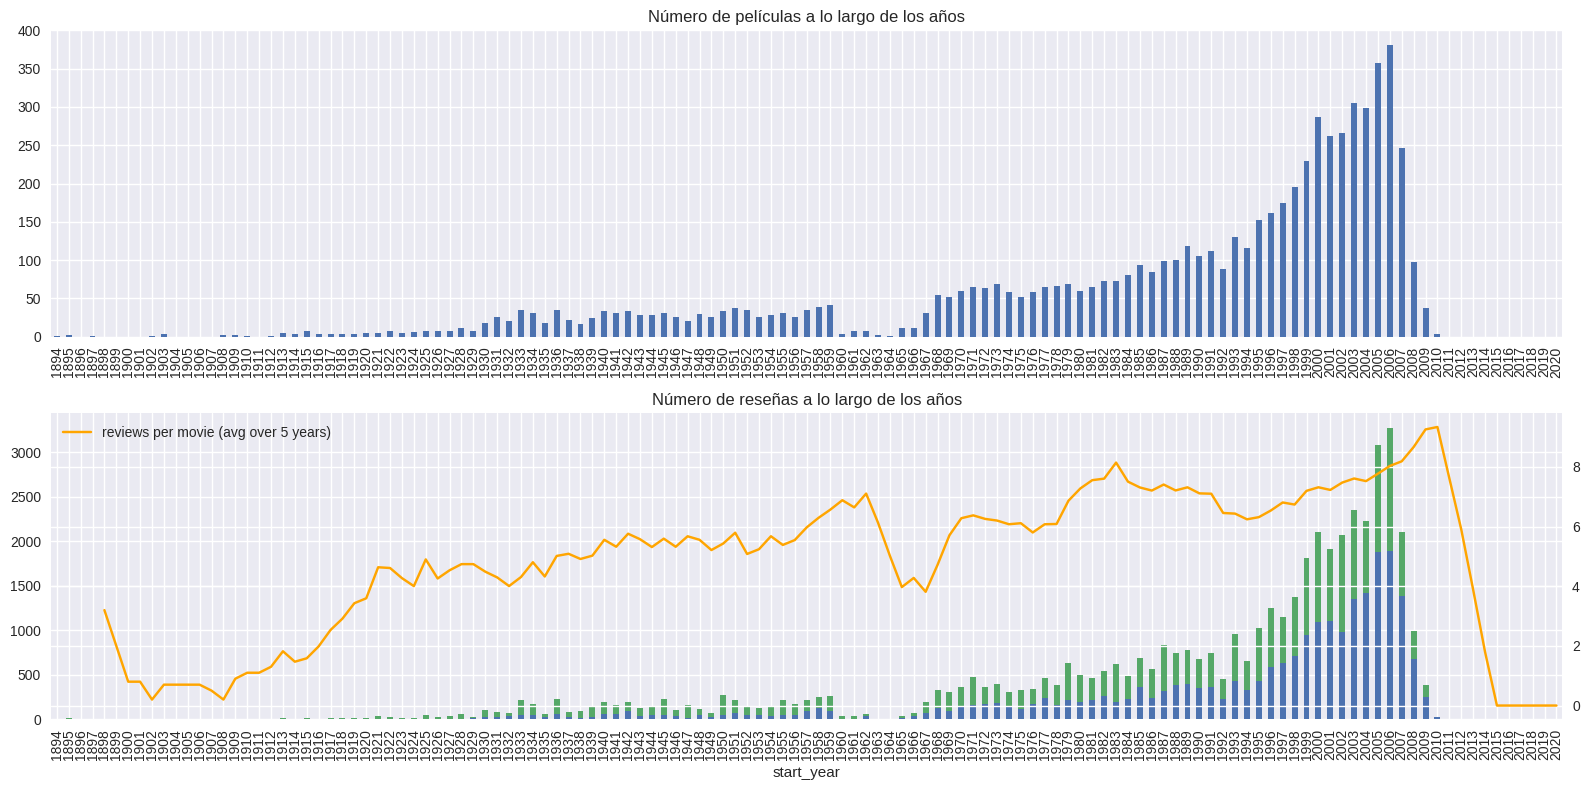

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

El primer gráfico nos muestra como ha aumentado la producción de peliculas a lo largo de los años mientras que el segundo nos muestra el aumento de reseñas a través del tiempo.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

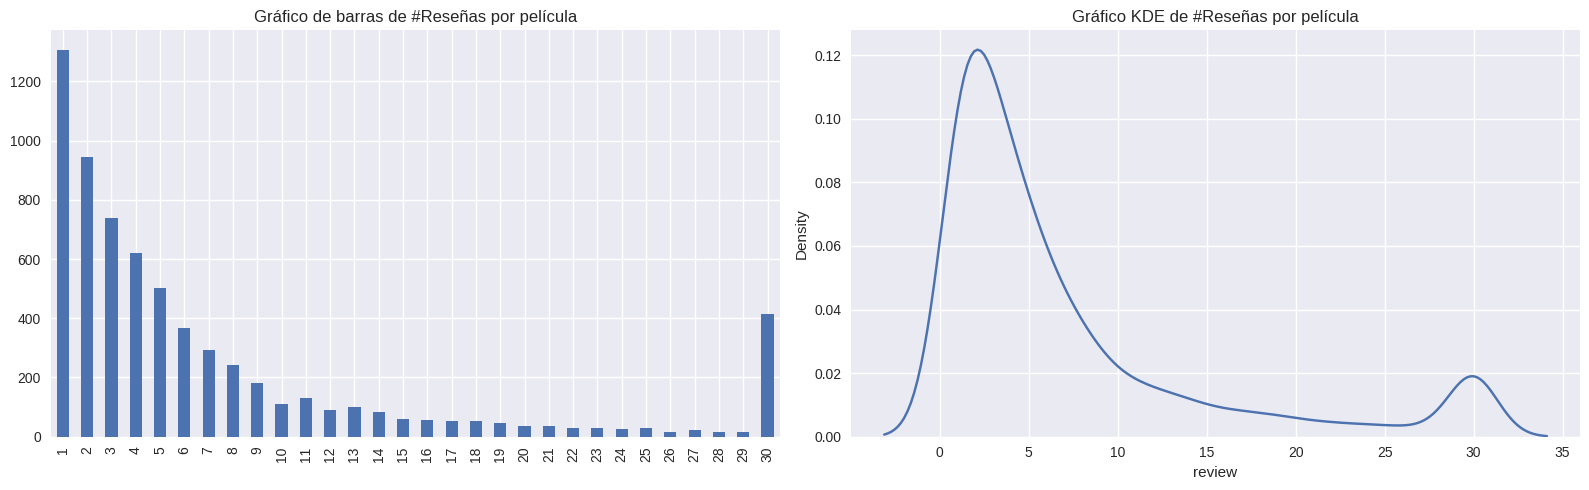

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Como se puede apreciar predominan las películas con un menos reseñas mientras que un número reducido de películas acumula un mayor número de reseñas. 

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

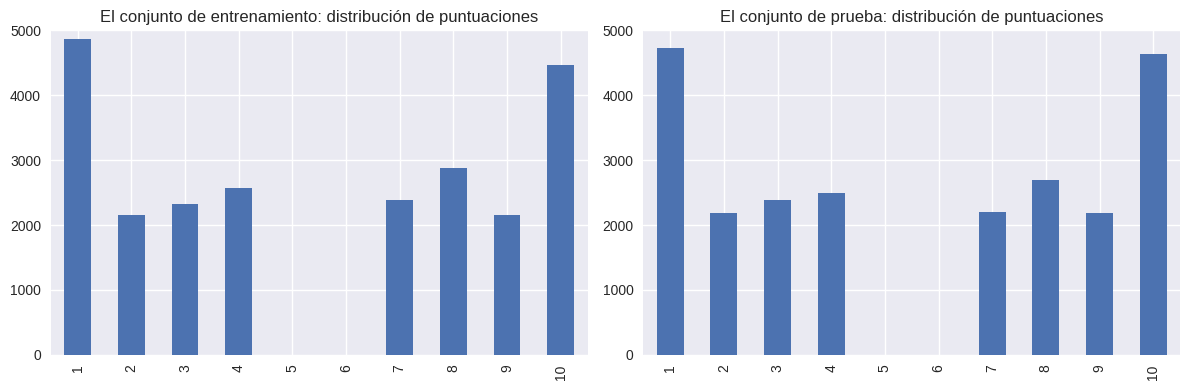

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Aquí se puede observar que el desequilibrio de clases es bajo ya que tenemos 23.715 valores negativos y 23.616 positivos, esto nos indica que  no es necesario equilibrar las clases, lo que proporciona una base sólida para realizar un análisis más preciso y confiable de las reseñas de películas.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


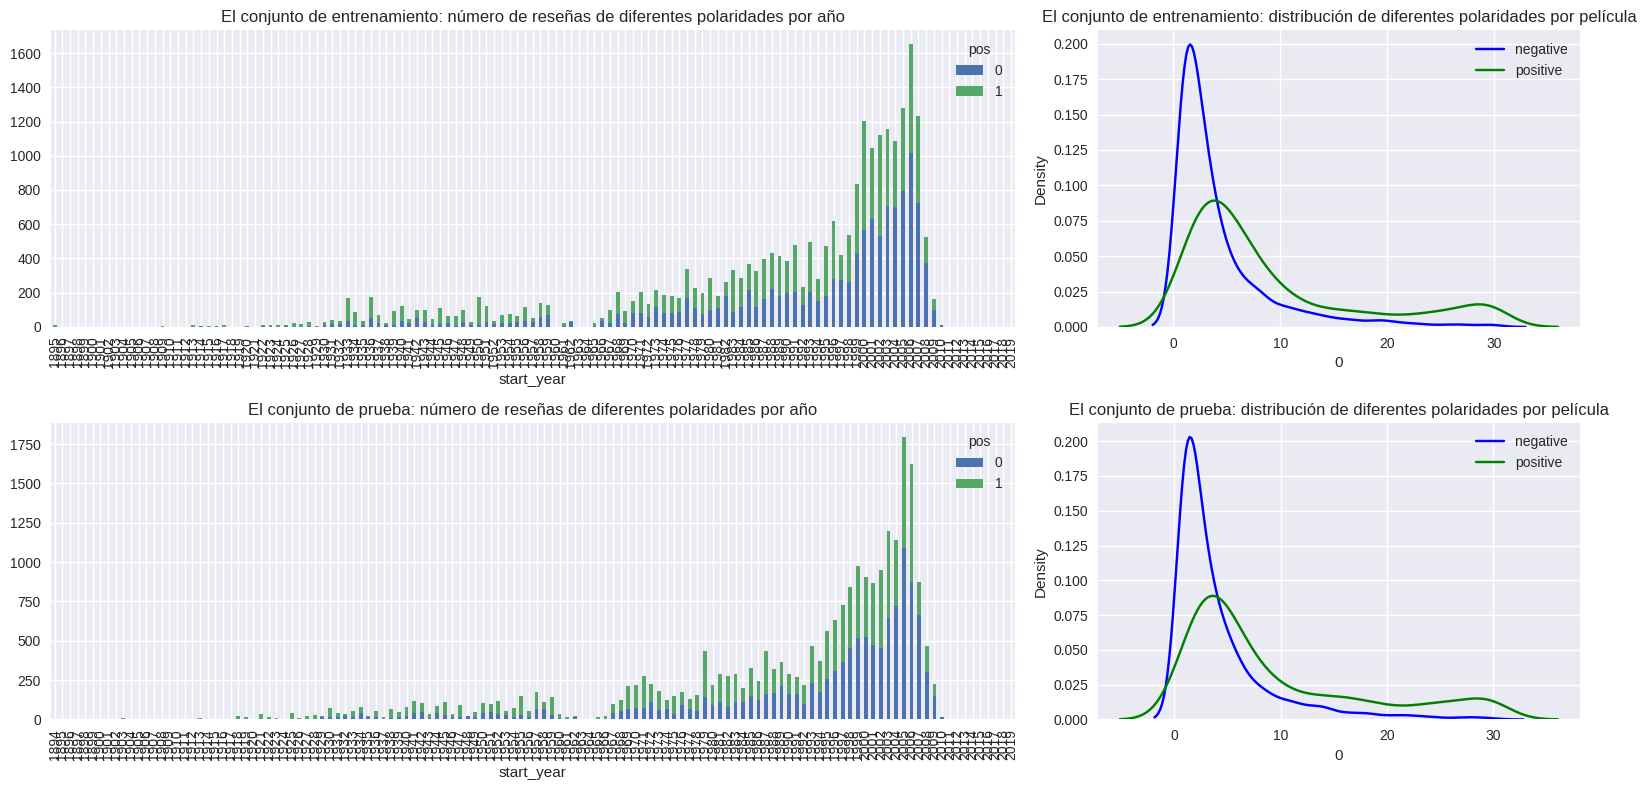

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Como se puede apreciar en ambos conjuntos se ve un patrón muy similar y conforme pasan los años la distribución de los reviews negativos y positivos se ven parejos, en cambio en el gráfico KDE se puede observar que las peliculas con menos reviews tienden a ser negativas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
import sklearn.metrics as metrics


def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

       
        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
# función para normalizar cualquier clase de texto.
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text


df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

  0%|          | 0/47331 [00:00<?, ?it/s]

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

           train  test
Exactitud    NaN   NaN
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


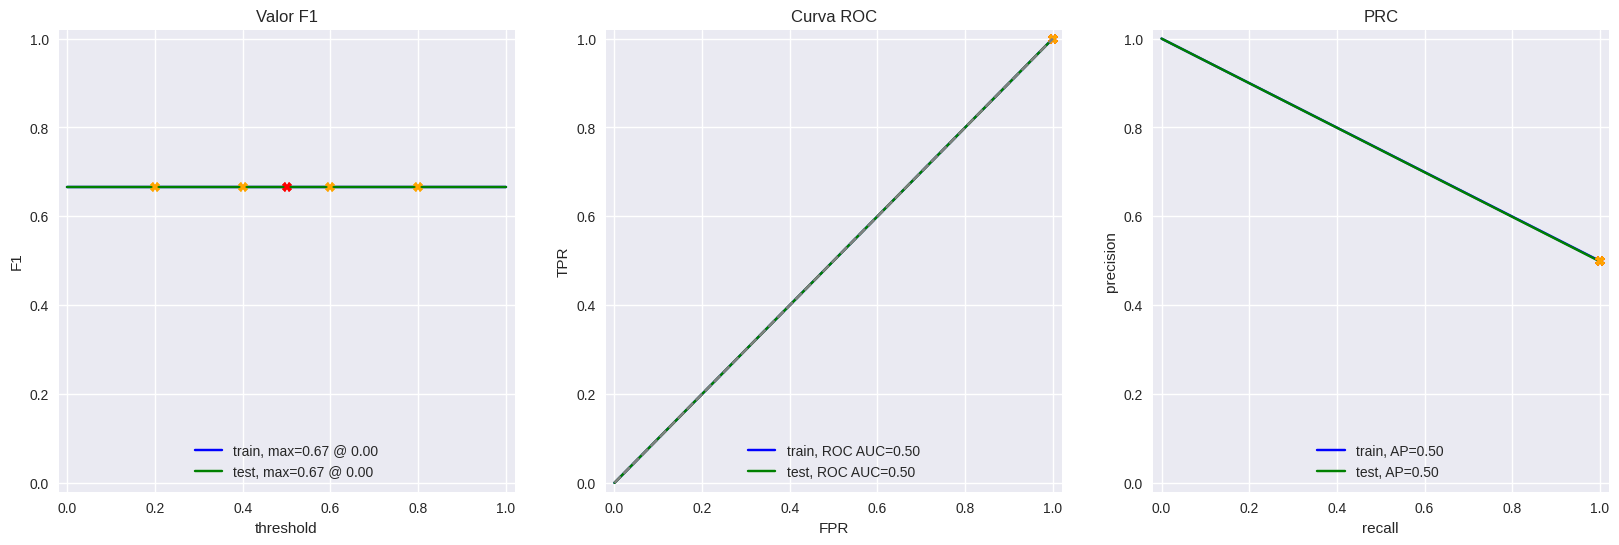

In [16]:
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(df_reviews_train['review_norm'], train_target)
evaluate_model(model_0, df_reviews_train['review_norm'],
               train_target, df_reviews_test['review_norm'], test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [17]:
# Función para tokenizar y lematizar el texto con NLTK

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(
        word) for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


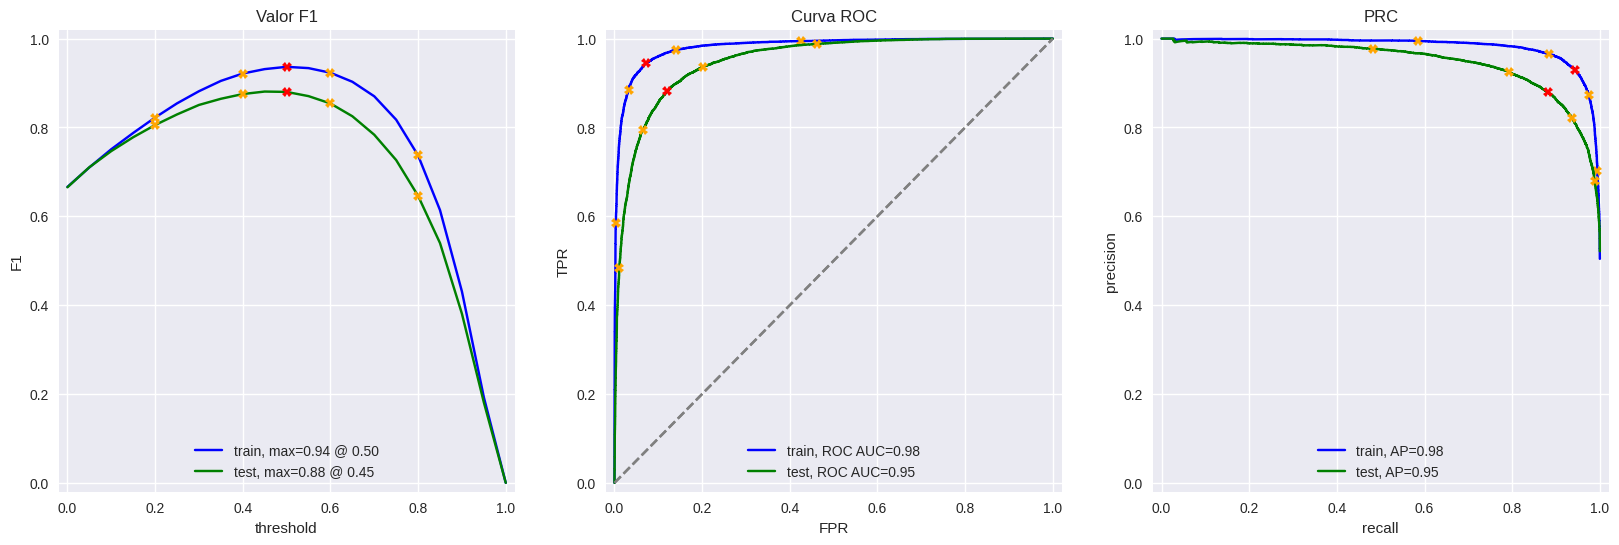

In [18]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

# lematizador
lemmatizer = WordNetLemmatizer()

# aplicacion de la función para preprocesar los sets
df_reviews_train['review_norm'] = df_reviews_train['review_norm'].apply(
    preprocess_text)
df_reviews_test['review_norm'] = df_reviews_test['review_norm'].apply(
    preprocess_text)

vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
train_features_1 = vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer_1.transform(df_reviews_test['review_norm'])

model_1 = LogisticRegression(max_iter=200)
model_1.fit(train_features_1, train_target)
evaluate_model(model_1, train_features_1, train_target,
               test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

           train  test
Exactitud    NaN   NaN
F1          0.93  0.87
APS         0.98  0.94
ROC AUC     0.98  0.94


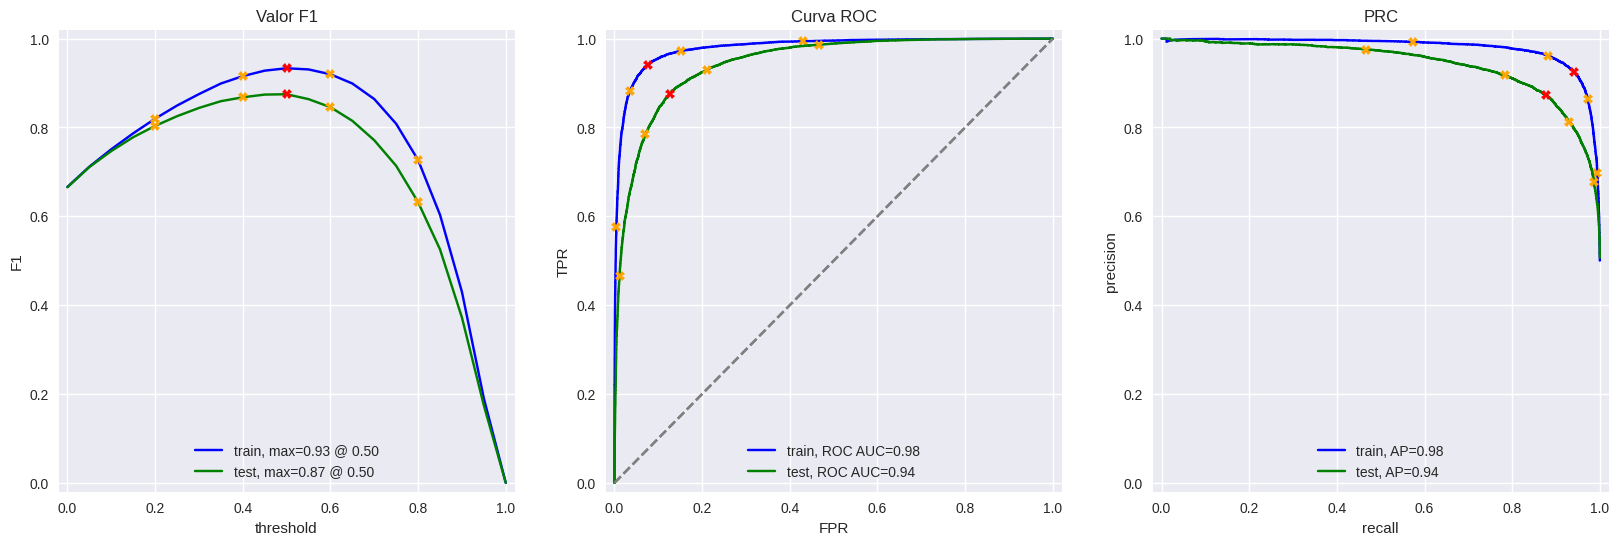

In [21]:
df_reviews_train['review_norm_3'] = df_reviews_train['review_norm'].progress_apply(
    text_preprocessing_3)
df_reviews_test['review_norm_3'] = df_reviews_test['review_norm'].progress_apply(
    text_preprocessing_3)

vectorizer_3 = TfidfVectorizer()
train_features_3 = vectorizer_3.fit_transform(
    df_reviews_train['review_norm_3'])
test_features_3 = vectorizer_3.transform(df_reviews_test['review_norm_3'])

model_3 = LogisticRegression(max_iter=200)
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target,
               test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

           train  test
Exactitud    NaN   NaN
F1          0.91  0.85
APS         0.97  0.93
ROC AUC     0.97  0.93


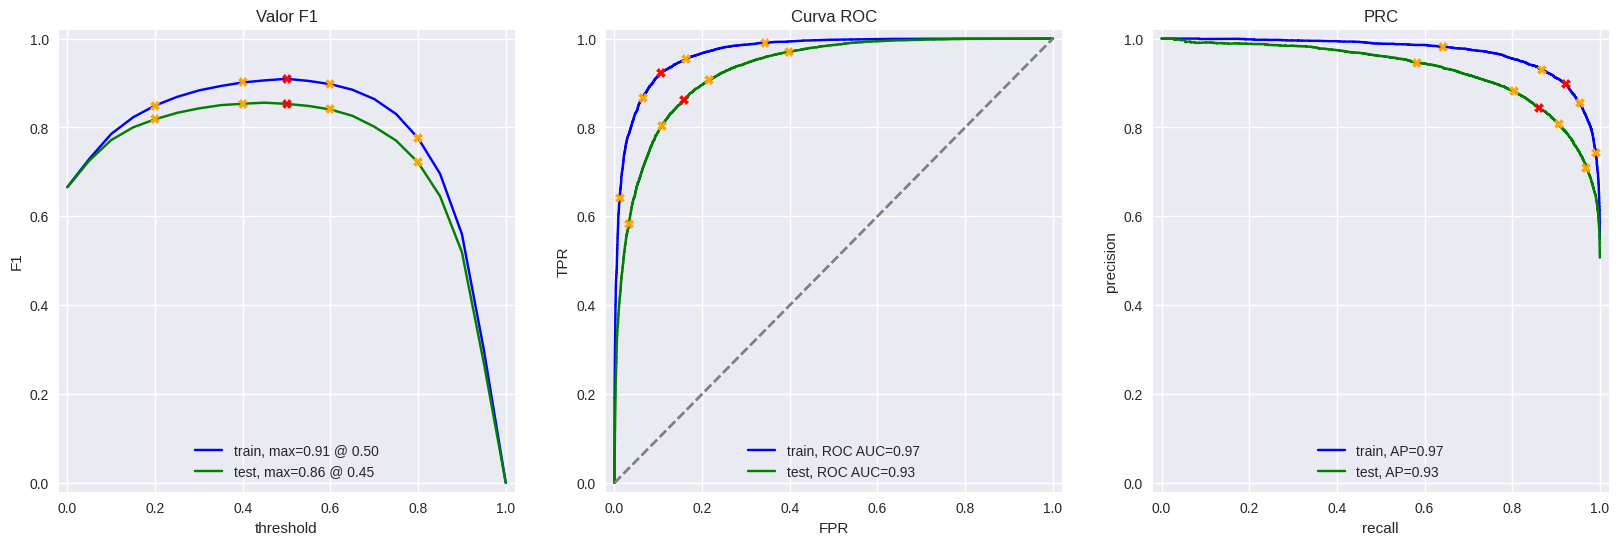

In [22]:
model_4 = LGBMClassifier()
model_4.fit(train_features_3, train_target)
evaluate_model(model_4, train_features_3, train_target,
               test_features_3, test_target)

## Mis reseñas

In [23]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize_text)

# Tokenización y lematización con la funcion anterior
my_reviews['review_norm_3'] = my_reviews['review_norm'].progress_apply(
    text_preprocessing_3)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

### Modelo 2

In [24]:
# Predicciones con el modelo 1
texts = my_reviews['review_norm']
my_reviews_pred_prob_1 = model_1.predict_proba(
    vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_1[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.29:  i didnt expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [25]:
texts_3 = my_reviews['review_norm_3']
my_reviews_pred_prob_3 = model_3.predict_proba(
    vectorizer_3.transform(texts_3))[:, 1]

for i, review in enumerate(texts_3.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.19:  simply like kind movie
0.09:  bored feel asleep middle movie
0.58:  fascinated movie
0.17:  actor look old disintereste get pay movie soulless cash grab
0.19:  not expect reboot good writer care source material
0.42:  movie upside downside feel like overall decent flick go
0.03:  rotten attempt comedy single joke land act annoying loud kid will not like
0.91:  launch netflix brave   appreciate able binge episode episode exciting intelligent new drama


### Modelo 4

In [26]:
my_reviews_pred_prob_4 = model_4.predict_proba(
    vectorizer_3.transform(texts_3))[:, 1]

for i, review in enumerate(texts_3.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.63:  simply like kind movie
0.33:  bored feel asleep middle movie
0.62:  fascinated movie
0.44:  actor look old disintereste get pay movie soulless cash grab
0.49:  not expect reboot good writer care source material
0.63:  movie upside downside feel like overall decent flick go
0.20:  rotten attempt comedy single joke land act annoying loud kid will not like
0.79:  launch netflix brave   appreciate able binge episode episode exciting intelligent new drama


## Conclusiones


Las conclusiones del proyecto son las siguientes:


Se entrenaron y evaluaron modelos de clasificación de sentimientos para reseñas de películas: NLTK, spaCy, y LGBM. Cada modelo utilizó diferentes técnicas de procesamiento de texto y algoritmos de aprendizaje automático connluyendo lo siguiente:


El modelo NLTK alcanzó un F1 Score de 0.88  lo que indica un buen rendimiento en la clasificación de las reseñas como positivas o negativas y se utilizó la técnica de lematización y TF-IDF para la vectorización de características.


El modelo spaCy obtuvo un F1 Score de 0.87, se utilizó la técnica de lematización y TF-IDF para el procesamiento de texto y aunque fue ligeramente inferior al modelo NLTK, sigue siendo un modelo efectivo en la clasificación de las reseñas.


El modelo LGBM alcanzó un F1 Score de 0.85,  se utilizó la técnica de preprocesamiento de texto spaCy y la técnica de vectorización TF-IDF y aunque presenta un rendimiento ligeramente inferior a los modelos anteriores, sigue siendo una opción válida.


Al final creo que aunque los otros modelos también cumplieron con el requisito mínimo, el mejor modelo y el que se debería escoger en mi opinión es el de NLTK.
